# 3D Cellpose + Baysor segmentation demo

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import sawg.segmentation

### Load a merscope experiment

In [2]:
expt_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1191380492/'
image_path = expt_path + 'images/'
csv_file = expt_path + 'detected_transcripts.csv'
cache_file = csv_file + '.npz'

max_rows = None
table = sawg.SpotTable.load_merscope(csv_file=csv_file, cache_file=cache_file, image_path=image_path, max_rows=max_rows)

Loading from npz..


### Pick a small tile to test on

In [3]:
# subrgn = np.array([[2050, 2250], [2000, 2200]])
subrgn = np.array([[2050, 2150], [2000, 2100]])

subtable = table.get_subregion(xlim=subrgn[0], ylim=subrgn[1])
dapi = subtable.get_image(channel='DAPI')
img_data = dapi.get_data()

### Peek at the data first

Here are the data we want to segment; spot table on the left, DAPI image on the right.
There are 7 imaging planes and onthe left we plot all 7 planes added together; on the right is the average of all 7 planes.

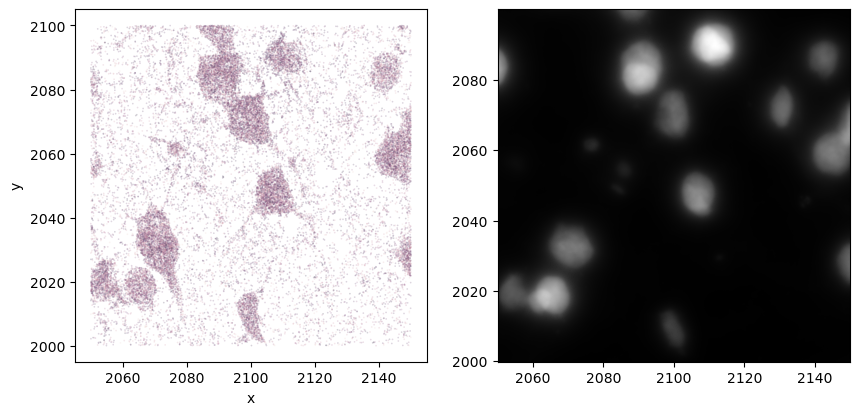

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subtable.scatter_plot(ax=ax[0])
dapi.show(ax=ax[1], frame='mean', cmap='gray')

## 2D Cellpose (nuclei only)
(disabled)

In [5]:
seg_2d = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': 'nuclei',
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {'nuclei': subtable.get_image(channel='DAPI').get_frame(3)}, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_2d = seg_2d.run(subtable)

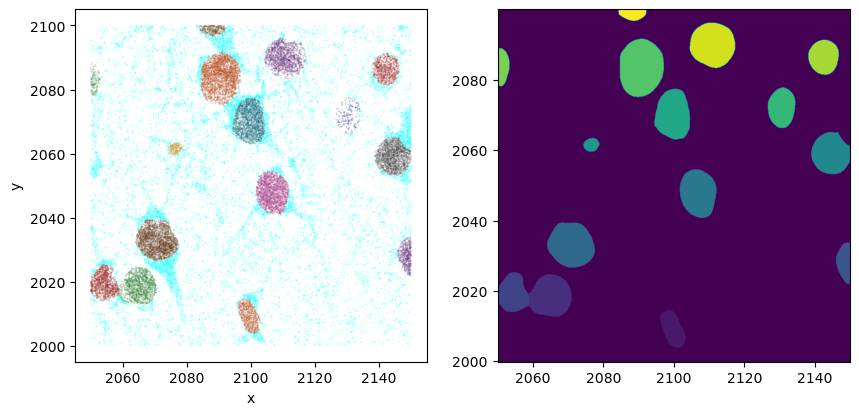

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

result_2d.spot_table().scatter_plot(ax=ax[0], color='cell')
result_2d.mask_image.show(ax[1])


## 3D Cellpose (nuclei only)

In [7]:
seg_dapi_3d = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': 'nuclei',
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {'nuclei': 'DAPI'}, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_dapi_3d = seg_dapi_3d.run(subtable)

Visualize the 3D cellpose segmentation

Right: segmentetd image masks
Left: Spots transformed to pixel space and colored by cell ID (to verify alignment)

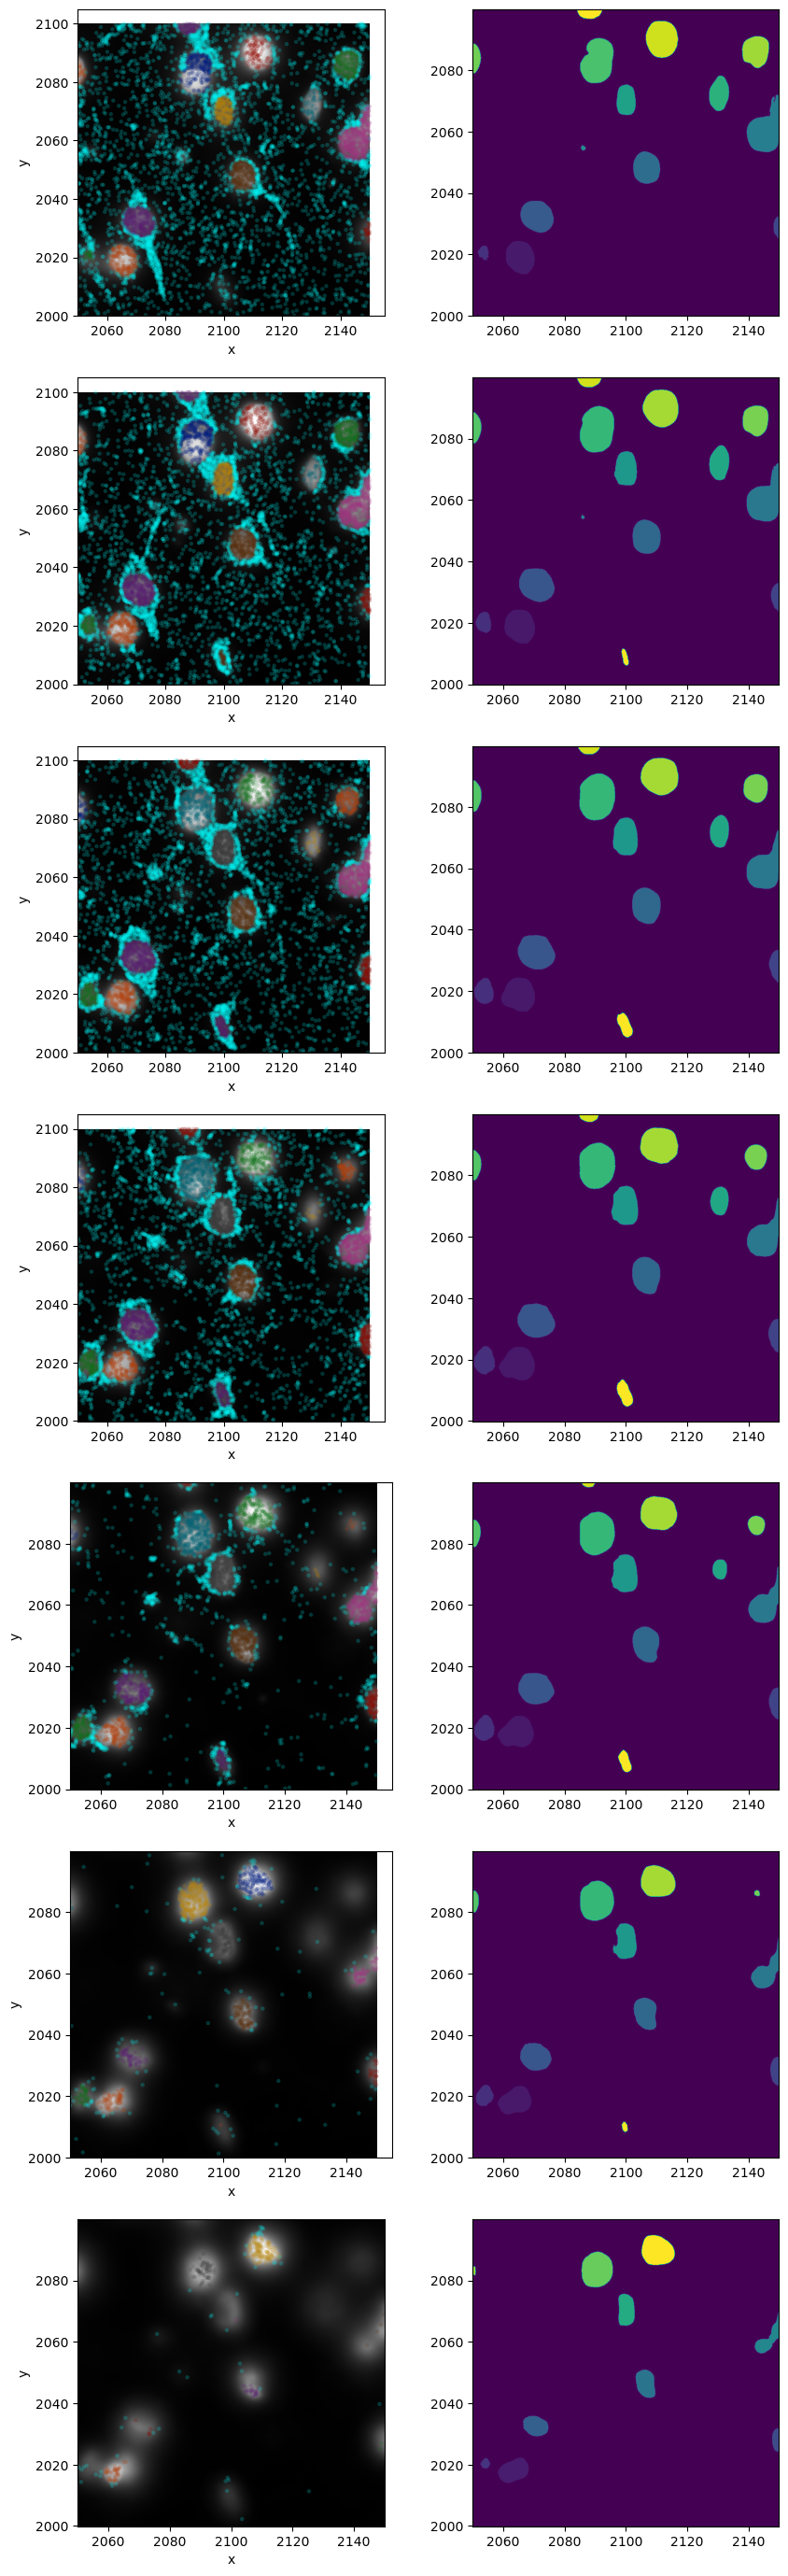

In [8]:
img = subtable.get_image(channel='DAPI')
n_planes = img.shape[0]

fig, ax = plt.subplots(n_planes, 2, figsize=(10, 5*n_planes))

for i in range(n_planes):
    img_layer = img.get_frame(i)
    img_layer.show(ax[i, 0], cmap='gray')
    mask_layer = result_dapi_3d.mask_image.get_frame(i)
    mask_layer.show(ax[i, 1])
    
    mask = subtable.z == i
    result_dapi_3d.spot_table()[mask].scatter_plot(ax=ax[i, 0], color='cell', size=10)


## Run cellpose using total mRNA as cytoplasm 'stain'

In [9]:
seg_tot_mrna = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': 'cyto2',
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {'cyto': 'total_mrna', 'nuclei': 'DAPI'}, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_tot_mrna = seg_tot_mrna.run(subtable)

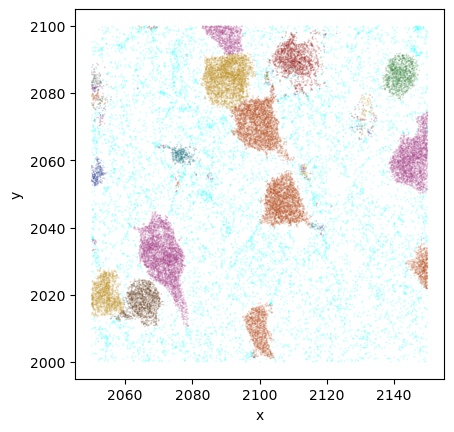

In [10]:
result_tot_mrna.spot_table().scatter_plot(color='cell')

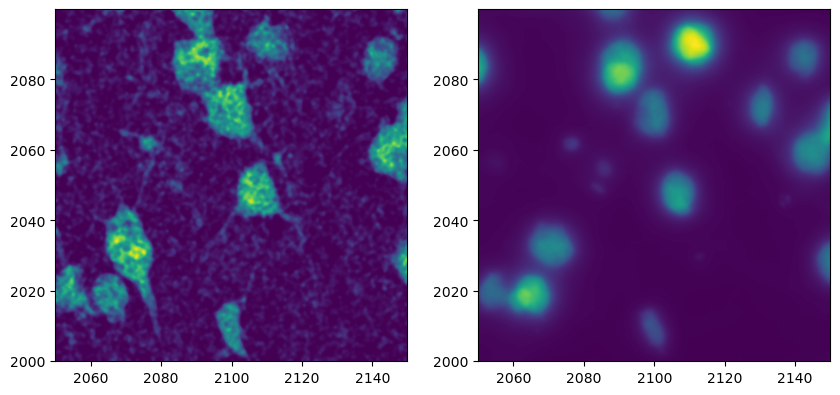

In [11]:
# Show images used for segmentation:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

result_tot_mrna.method.images['cyto'].show(ax=ax[0], frame='mean')
result_tot_mrna.method.images['nuclei'].show(ax=ax[1], frame='mean')

## Cellpose cyto2 using PolyT

In [12]:
seg_polyt = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': 'cyto2',
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {'cyto': 'PolyT', 'nuclei': 'DAPI'}, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_polyt = seg_polyt.run(subtable)

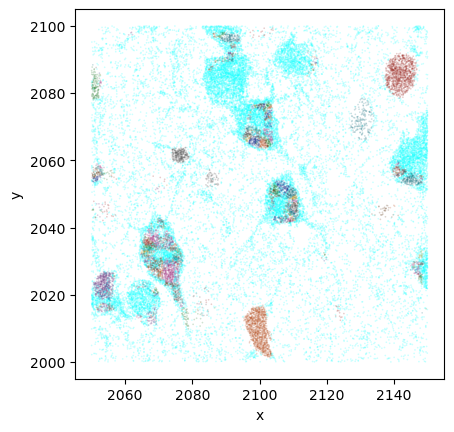

In [14]:
result_polyt.spot_table().scatter_plot(color='cell')

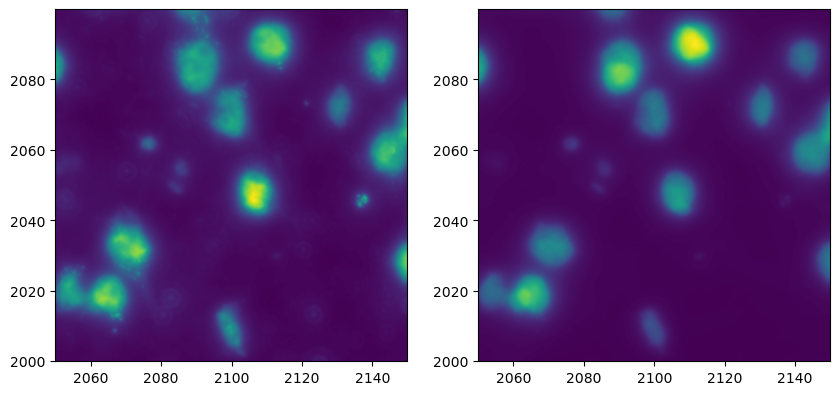

In [15]:
# Show images used for segmentation:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

result_polyt.method.images['cyto'].show(ax=ax[0], frame='mean')
result_polyt.method.images['nuclei'].show(ax=ax[1], frame='mean')

### Run Baysor, using cellpose as prior

In [16]:
# start with cellpose 3D nuclei as prior 
prior_spot_table = result_dapi_3d.spot_table()

# baysor_bin = '../../baysor-docker/Baysor'  # older version
# baysor_bin = '../../baysor-latest/bin/Baysor'  # Cannot locate artifact 'MKL'
# baysor_bin = '../../baysor-git/bin/Baysor'  # compile fails
baysor_bin = '../../baysor-old/bin/Baysor'  # 0.5.1 working, no new-component-weight
# baysor_bin = '../../baysor-julia/Baysor'  # 0.5.2 working, verrrry slow startup

seg = sawg.segmentation.BaysorSegmentationMethod(options = {
    'region': None,
    'baysor_bin': baysor_bin,
#     'baysor_output_path': '/path/to/baysor/data',
    'use_prior_segmentation': True,
    'no_gene_names': False,          # if true, remove gene names
    'cell_dia': 10,                  # um
    'z_plane_thickness': 1.5,        # um
    'baysor_options': {
        'scale-std': '25%',
        'prior-segmentation-confidence': None,
        'n-clusters': None,
        'no-ncv-estimation': True,
    }
})
result_baysor = seg.run(prior_spot_table)

┌ Warning: No config file provided. Using default parameters.
└ @ Baysor /home/runner/work/Baysor/Baysor/src/cli/main.jl:96


[07:13:50] Info: (2023-02-18) Run Baysor v0.5.1
[07:13:50] Info: Loading data...
[07:13:58] Info: Loaded 32484 transcripts
[07:13:59] Info: Estimating noise level
[07:13:59] Warning: Only k-nn random field is supported for 3D data
└ Baysor /home/runner/work/Baysor/Baysor/src/data_processing/triangulation.jl:30
[07:13:59] Info: Done
[07:13:59] Warning: Only k-nn random field is supported for 3D data
└ Baysor /home/runner/work/Baysor/Baysor/src/data_processing/triangulation.jl:30
[07:14:00] Info: Clustering molecules...
[07:14:00] Warning: Only k-nn random field is supported for 3D data
└ Baysor /home/runner/work/Baysor/Baysor/src/data_processing/triangulation.jl:30


Progress:   0%|▏                                        |  ETA: 0:01:26
  Iteration:                  36
  Max. difference:            0.019777807517498282
raction of probs changed:  0.7466137175224726


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  Iteration:                  73
  Max. difference:            0.0011298428565448195
  Fraction of probs changed:  0.43107375938923775


[07:14:02] Info: Algorithm stopped after 73 iterations. Error: 0.00113. Converged: true.
[07:14:02] Info: Done
[07:14:02] Info: Initializing algorithm. Scale: 10.0, scale std: 2.5, initial #components: 16, #molecules: 32484.
[07:14:02] Info: Using 3D coordinates


Progress:   1%|▎                                        |  ETA: 0:00:29
  Iteration:        3
  Noise level, %:   19.19
um. components:  396


Progress:   1%|▍                                        |  ETA: 0:00:32
  Iteration:        5
  Noise level, %:   24.61
um. components:  175


Progress:   1%|▌                                        |  ETA: 0:00:41
  Iteration:        6
  Noise level, %:   27.06
um. components:  1118


Progress:   1%|▋                                        |  ETA: 0:00:54
  Iteration:        7
  Noise level, %:   25.85
um. components:  620


Progress:   2%|▊                                        |  ETA: 0:00:55
  Iteration:        9
  Noise level, %:   27.63
um. components:  1556


Progress:   2%|▉                                        |  ETA: 0:00:55
  Iteration:        10
  Noise level, %:   26.08
um. components:  880


Progress:   2%|█                                        |  ETA: 0:00:56
  Iteration:        12
  Noise level, %:   27.6
um. components:  15

um. components:  907


Progress:  16%|██████▋                                  |  ETA: 0:00:53
  Iteration:        81
  Noise level, %:   27.35
um. components:  1467


Progress:  16%|██████▊                                  |  ETA: 0:00:53
  Iteration:        82
  Noise level, %:   25.9
um. components:  914


Progress:  17%|██████▉                                  |  ETA: 0:00:53
  Iteration:        84
  Noise level, %:   27.36
um. components:  1468


Progress:  17%|███████                                  |  ETA: 0:00:53
  Iteration:        85
  Noise level, %:   25.87
um. components:  915


Progress:  17%|███████▏                                 |  ETA: 0:00:52
  Iteration:        87
  Noise level, %:   27.42
um. components:  1381


Progress:  18%|███████▎                                 |  ETA: 0:00:52
  Iteration:        88
  Noise level, %:   25.88
um. components:  827


Progress:  18%|███████▍                                 |  ETA: 0:00:52
  Iteration:        90
  Noise level, %

um. components:  747


Progress:  31%|████████████▊                            |  ETA: 0:00:42
  Iteration:        156
  Noise level, %:   27.4
um. components:  1581


Progress:  31%|████████████▉                            |  ETA: 0:00:42
  Iteration:        157
  Noise level, %:   25.95
um. components:  948


Progress:  32%|█████████████                            |  ETA: 0:00:42
  Iteration:        159
  Noise level, %:   27.33
um. components:  1351


Progress:  32%|█████████████▏                           |  ETA: 0:00:42
  Iteration:        160
  Noise level, %:   25.79
um. components:  839


Progress:  32%|█████████████▎                           |  ETA: 0:00:41
  Iteration:        162
  Noise level, %:   27.45
um. components:  1398


Progress:  33%|█████████████▍                           |  ETA: 0:00:41
  Iteration:        163
  Noise level, %:   25.92
um. components:  847


Progress:  33%|█████████████▌                           |  ETA: 0:00:41
  Iteration:        165
  Noise l

um. components:  953


Progress:  46%|███████████████████                      |  ETA: 0:00:33
  Iteration:        231
  Noise level, %:   27.11
um. components:  1389


Progress:  46%|███████████████████                      |  ETA: 0:00:33
  Iteration:        232
  Noise level, %:   25.74
um. components:  863


Progress:  47%|███████████████████▎                     |  ETA: 0:00:32
  Iteration:        234
  Noise level, %:   27.33
um. components:  1317


Progress:  47%|███████████████████▎                     |  ETA: 0:00:32
  Iteration:        235
  Noise level, %:   25.77
um. components:  829


Progress:  47%|███████████████████▍                     |  ETA: 0:00:32
  Iteration:        237
  Noise level, %:   27.12
um. components:  1309


Progress:  48%|███████████████████▌                     |  ETA: 0:00:32
  Iteration:        238
  Noise level, %:   25.71
um. components:  768


Progress:  48%|███████████████████▋                     |  ETA: 0:00:31
  Iteration:        240
  Noise 

um. components:  834


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:23
  Iteration:        309
  Noise level, %:   27.31
um. components:  1449


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:23
  Iteration:        310
  Noise level, %:   25.85
um. components:  885


Progress:  62%|█████████████████████████▋               |  ETA: 0:00:23
  Iteration:        312
  Noise level, %:   27.26
um. components:  1395


Progress:  63%|█████████████████████████▋               |  ETA: 0:00:23
  Iteration:        313
  Noise level, %:   25.83
um. components:  876


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:22
  Iteration:        315
  Noise level, %:   27.44
um. components:  1595


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:22
  Iteration:        316
  Noise level, %:   25.94
um. components:  1047


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:22
  Iteration:        318
  Noise

um. components:  746


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:14
  Iteration:        384
  Noise level, %:   27.31
um. components:  1456


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:14
  Iteration:        385
  Noise level, %:   25.99
um. components:  895


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:14
  Iteration:        387
  Noise level, %:   27.36
um. components:  1402


Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:13
  Iteration:        388
  Noise level, %:   25.97
um. components:  852


Progress:  78%|████████████████████████████████         |  ETA: 0:00:13
  Iteration:        390
  Noise level, %:   27.2
um. components:  1245


Progress:  78%|████████████████████████████████         |  ETA: 0:00:13
  Iteration:        391
  Noise level, %:   25.76
um. components:  765


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:13
  Iteration:        393
  Noise l

um. components:  788


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:05
  Iteration:        459
  Noise level, %:   27.16
um. components:  1416


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:05
  Iteration:        460
  Noise level, %:   26.05
um. components:  812


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:05
  Iteration:        462
  Noise level, %:   26.93
um. components:  1190


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:04
  Iteration:        463
  Noise level, %:   25.79
um. components:  706


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:04
  Iteration:        465
  Noise level, %:   27.13
um. components:  1295


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04
  Iteration:        466
  Noise level, %:   25.96
um. components:  772


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:04
  Iteration:        468
  Noise 

[07:15:03] Info: Processing complete.
[07:15:04] Info: Saving results to /tmp/baysor_run_n2bej_fj/output_spot_table.csv
[07:15:04] Info: All done!


Text(0.5, 1.0, 'baysor segmentation')

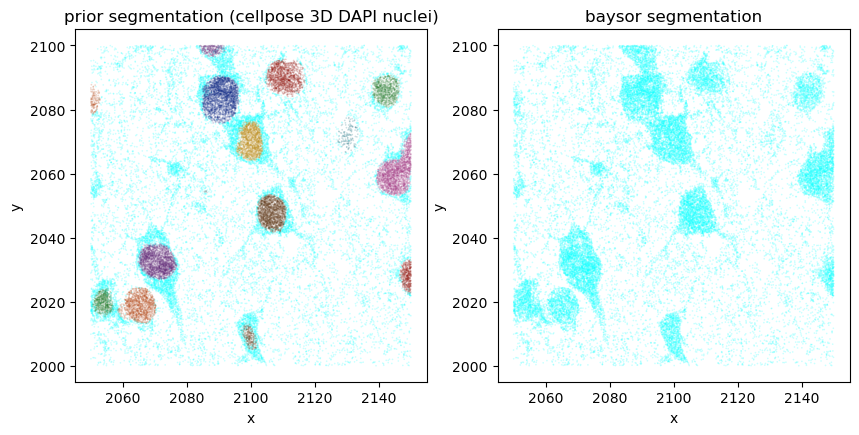

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

prior_spot_table.scatter_plot(ax=ax[0], color='cell')
ax[0].set_title('prior segmentation (cellpose 3D DAPI nuclei)')
result_baysor.spot_table().scatter_plot(ax=ax[1], color='cell')
ax[1].set_title('baysor segmentation')